In [9]:
import pandas as pd
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import random
from sklearn.metrics.pairwise import cosine_similarity
import math
import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS

In [10]:
import psycopg2 as pg2
import psycopg2.extras as pgex
this_host='34.211.59.66'
this_user='postgres'
this_password='postgres'
conn = pg2.connect(host = this_host, 
                        user = this_user,
                        password = this_password)

sql_select = '''select created_at, location, tweet_content, cleaned_tweet, hashtags from tweets;'''

cur = conn.cursor(cursor_factory=pgex.RealDictCursor)
cur.execute(sql_select)
rows = cur.fetchall()
conn.close()
df = pd.DataFrame(rows)
df.reset_index(inplace = True)

In [11]:
import pickle
!pip install redis
import redis
redis_ip = '34.211.59.66'
r = redis.StrictRedis(redis_ip)
r.keys()

[b'tweet_SVD_fit',
 b'hashtags_countvec_fit_temp',
 b'hashtag_tfidf',
 b'temp_hash_count_12hr',
 b'hashtags_countvec_fit_transform',
 b'hashtags_tfidf_fit_transform',
 b'tweet_tfidf_fit',
 b'hashtags_countvec_fit',
 b'tweets_tfd_svd_pipe',
 b'tweet_tfidf_fit_transform']

In [23]:
tfd_svd_pipe = pickle.loads(r.get('tweets_tfd_svd_pipe'))

In [24]:
TFIDF_fit =  tfd_svd_pipe.steps[0][1]
SVD_fit = tfd_svd_pipe.steps[1][1]

TFIDF_fit = pickle.loads(r.get('tweet_tfidf_fit'))
SVD_fit = pickle.loads(r.get('tweet_SVD_fit'))

In [13]:
def event_tweet_count(event):
    event = event.lower()
    event_tweet = df[df['cleaned_tweet'].str.contains((event))]
    return len(event_tweet)

In [14]:
def tweets_event_ab_test(event):
    event = event.lower()
    event_tweet = df[df['cleaned_tweet'].str.contains((event))]
    event_tweet.reset_index(inplace = True)
    
    A_index = list(range(event_tweet.shape[0]))
    random.shuffle(A_index)
    
    n = int(round((event_tweet_count(event))*0.2,0))
    A1_index = []
    for i in range(n):
        A1_index.append(A_index.pop())
    
    A1 = event_tweet.iloc[A1_index,:]
    A1_vec = np.array([SVD_fit.transform(TFIDF_fit.transform([i])).ravel() for i in A1['cleaned_tweet']])

    A2 = event_tweet.iloc[A_index,:] 
    #A2.reset_index(inplace = True)
    A2_vec = np.array([SVD_fit.transform(TFIDF_fit.transform([i])).ravel() for i in A2['cleaned_tweet']])
    non_event_tweet = df[~df['cleaned_tweet'].str.contains(('event'))]
    non_event_tweet.reset_index(inplace = True)
    
    B_index = list(range(non_event_tweet.shape[0]))
    random.shuffle(B_index)
    n = n
    B1_index = []
    for i in range(n):
        B1_index.append(B_index.pop())
    m = A2.shape[0]
    B2_index = []
    for i in range(m):
        B2_index.append(B_index.pop())  
    
    B1 = non_event_tweet.iloc[B1_index,:]
    B1_vec = np.array([SVD_fit.transform(TFIDF_fit.transform([i])).ravel() for i in B1['cleaned_tweet']])
    
    B2 = non_event_tweet.iloc[B2_index,:]
    B2_vec = np.array([SVD_fit.transform(TFIDF_fit.transform([i])).ravel() for i in B2['cleaned_tweet']])
    
    A1_vec_mean = np.mean(A1_vec, axis=0)
    A2_vec_mean = np.mean(A2_vec, axis=0)
    B1_vec_mean = np.mean(B1_vec, axis=0)
    B2_vec_mean = np.mean(B2_vec, axis=0)
    
    a1a2 = cosine_similarity(A1_vec_mean.reshape(1,-1),A2_vec_mean.reshape(1,-1))[0][0]
    b1b2 = cosine_similarity(B2_vec_mean.reshape(1,-1),B1_vec_mean.reshape(1,-1))[0][0]
    a1b1 = cosine_similarity(A1_vec_mean.reshape(1,-1),B1_vec_mean.reshape(1,-1))[0][0]
    a2b2 = cosine_similarity(A2_vec_mean.reshape(1,-1),B2_vec_mean.reshape(1,-1))[0][0]
   
    a2_consim_list = []
    for i in range(min(n,m)):  
        a2_consim_list.append(cosine_similarity(A2_vec[i].reshape(1,-1),A1_vec_mean.reshape(1,-1))[0][0])
    a2_mean = np.mean(np.array(a2_consim_list))
    a2_std = np.std(np.array(a2_consim_list))
    
    b2_consim_list = []
    for i in range(min(n,m)):  
        b2_consim_list.append(cosine_similarity(B2_vec[i].reshape(1,-1),B1_vec_mean.reshape(1,-1))[0][0])
    b2_mean = np.mean(b2_consim_list)
    b2_std = np.std(b2_consim_list)
    
    a1b2_consim_list = []
    for i in range(min(n,m)):  
        a1b2_consim_list.append((cosine_similarity(B2_vec[i].reshape(1,-1),A1_vec_mean.reshape(1,-1))[0][0]))
    a1b2_mean = np.mean(a1b2_consim_list)
    a1b2_std = np.std(a1b2_consim_list)
    
    print('A1|A2: ',round(a1a2,3),'\n'
                'B1|B2: ',round(b1b2,3), '\n\n'
                'A1|B1: ',round(a1b1,3), '\n'
                'A2|B2: ', round(a2b2,3), '\n\n'
                'Cosine Similarity Mean of A2 to A1', round(a2_mean,3), '\n'
                'Cosine Similarity Mean of B2 to B1', round(b2_mean,3), '\n'
                'Cosine Similarity Mean of B2 to A1', round(a1b2_mean,3), '\n\n'
                'Cosine Similarity STD of A2 to A1', round(a2_std,3), '\n'
                'Cosine Similarity STD of B2 to B1', round(b2_std,3), '\n'
                'Cosine Similarity STD of B2 to A1', round(a1b2_std,3), '\n'                 
                )
    
    return a2_consim_list, b2_consim_list

In [15]:
def check_score_cluster(event,check_by_score = .7,high_score = .9):
    event = event.lower()
    event_tweet = df[df['cleaned_tweet'].str.contains((event))]
    event_tweet.reset_index(inplace = True, drop=True)
    A_index = list(range(event_tweet.shape[0]))
    random.shuffle(A_index)

    n = int(round((event_tweet_count(event))*0.5,0))
    A1_index = []
    for i in range(n):
        A1_index.append(A_index.pop())

    A1 = event_tweet.iloc[A1_index,:]
    A1.reset_index(inplace = True, drop=True)
    A1_vec = SVD_fit.transform(TFIDF_fit.transform(A1['cleaned_tweet']))

    A2 = event_tweet.iloc[A_index,:] 
    A2_vec = SVD_fit.transform(TFIDF_fit.transform(A2['cleaned_tweet']))
    A1_vec_mean = np.mean(A1_vec, axis=0)
    A2_vec_mean = np.mean(A2_vec, axis=0)

    consim_twt_list = []
    for i in range(len(A1)):  
        consim_twt_list.append((cosine_similarity(A1_vec[i].reshape(1,-1),A2_vec_mean.reshape(1,-1))[0][0], A1['cleaned_tweet'][i]))
    #pd.options.display.max_colwidth = 200
    result = pd.DataFrame(consim_twt_list, columns = ['score','tweet'])
    cluster1 = result[result['score']>high_score].sort_values('score', ascending = False)
    cluster2 = result[((result['score']<(check_by_score+.05)) & (result['score']>(check_by_score-.05)))]\
                .sort_values('score', ascending = False)
    return pd.concat([cluster1.reset_index().head(30), cluster2.reset_index().head(30)], axis=1)

In [16]:
def Top_scored_tweets_in_B(event, n = 10000):
    event = event.lower()
    A = df[df['cleaned_tweet'].str.contains((event))]
    A.reset_index(inplace = True, drop=True)
    A_vec = SVD_fit.transform(TFIDF_fit.transform(A['cleaned_tweet']))
    A_vec_mean = np.average(A_vec, axis=0)
       
    B = df[~df['cleaned_tweet'].str.contains((event))]
    B_index = list(range(B.shape[0]))
    random.shuffle(B_index)
    n = n
    B1_index = []
    for i in range(n):
        B1_index.append(B_index.pop())
        
    B1 = B.iloc[B1_index,:]
    B1.reset_index(inplace = True, drop=True)
    B1_vec = SVD_fit.transform(TFIDF_fit.transform(B1['cleaned_tweet']))
    
    consim_twt_list = []
    for i in range(n):  
        consim_twt_list.append((cosine_similarity(B1_vec[i].reshape(1,-1),A_vec_mean.reshape(1,-1))[0][0], B1['cleaned_tweet'][i]))
    pd.options.display.max_colwidth = 200
    result = pd.DataFrame(consim_twt_list, columns = ['score','tweet'])
    cluster = result[result['score']>.7].sort_values('score', ascending = False)
    pd.set_option('display.max_colwidth', -1)
    return cluster.head(20)

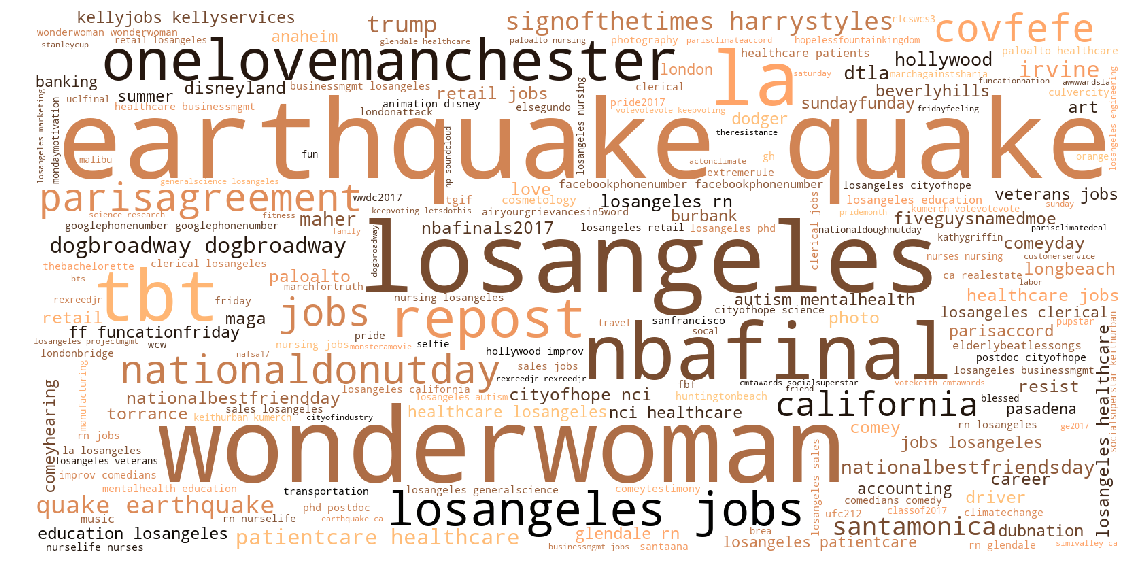

In [37]:
words = df['hashtags'][(df['hashtags'].isnull() == False) & (df['hashtags'] != 'None')]
stopwords = set(STOPWORDS)
stopwords.add("job")
stopwords.add("careerarc")
stopwords.add("hiring")
wc = WordCloud(width=1600, height=800, background_color='white', \
               relative_scaling=1, stopwords=stopwords, colormap='copper').generate(' '.join(i for i in words))


plt.figure(figsize=(20,10))
plt.imshow(wc)
plt.axis("off")
plt.show()

Event Tweets (paris|climate):  2627
A1|A2:  0.995 
B1|B2:  0.989 

A1|B1:  0.876 
A2|B2:  0.89 

Cosine Similarity Mean of A2 to A1 0.436 
Cosine Similarity Mean of B2 to B1 0.311 
Cosine Similarity Mean of B2 to A1 0.29 

Cosine Similarity STD of A2 to A1 0.14 
Cosine Similarity STD of B2 to B1 0.119 
Cosine Similarity STD of B2 to A1 0.152 



(-0.1, 1)

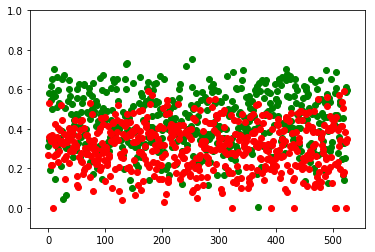

In [25]:
print('Event Tweets (paris|climate): ', event_tweet_count('paris|climate'))
A, B = tweets_event_ab_test('paris|climate')
plt.scatter(range(len(A)), A, c = 'g')
plt.scatter(range(len(B)), B, c = 'r')
plt.ylim(-.1,1)

In [47]:
check_score_cluster('paris|climate',.3, .7)

,index,score,tweet,index,score,tweet
0,1035.0,0.754705,omg michael bloomberg offers to pay the share ...,496,0.349720,"""caused by mankind is behind climate change."" 2/"
1,73.0,0.754257,confirming we live in a backward reality: form...,1164,0.347362,i hope climate take both of you!!!
2,854.0,0.750854,"""we, the people of the united states, sign on ...",782,0.347002,republicans should stop saying that they don't...
3,178.0,0.750112,without the us in the paris climate change acc...,657,0.345484,there is no conflict between climate change an...
4,960.0,0.742667,makes no sense to pull out of the paris agreem...,1081,0.344754,"tune in tomorrow, 6/9 at 8:45 am for our fb li..."
5,384.0,0.742073,pull out of the paris deal and look like the ...,179,0.344387,"sir, what do you see when you look in the mir..."
6,1254.0,0.738823,i hate to break it to him but his job is gone...,414,0.343520,tonight! ingenuethestar returns to host #thedr...
7,1192.0,0.729355,joe walsh is a crank and you know that. he br...,322,0.343344,so...had this deal been brokered in pittsburg...
8,651.0,0.728281,i find it shocking that the future of the eart...,198,0.343242,what's next for the paris accord. my inhabitat...
9,8.0,0.726520,again the anger comes out in hurling insults....,1178,0.343242,what's next for the paris accord. my inhabitat...


Event Tweets (nbafinals):  1178
A1|A2:  0.98 
B1|B2:  0.979 

A1|B1:  0.886 
A2|B2:  0.914 

Cosine Similarity Mean of A2 to A1 0.366 
Cosine Similarity Mean of B2 to B1 0.317 
Cosine Similarity Mean of B2 to A1 0.293 

Cosine Similarity STD of A2 to A1 0.162 
Cosine Similarity STD of B2 to B1 0.13 
Cosine Similarity STD of B2 to A1 0.159 



(-0.1, 1.2)

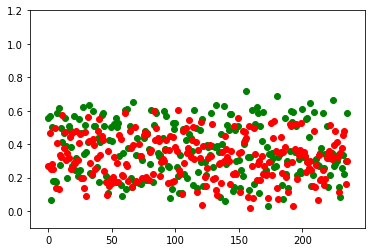

In [48]:
print('Event Tweets (nbafinals): ', event_tweet_count('nbafinals'))
A, B = tweets_event_ab_test('nbafinals')
plt.scatter(range(len(A)), A, c = 'g')
plt.scatter(range(len(B)), B, c = 'r')
plt.ylim(-.1,1.2)

In [51]:
#check high score tweets (>0.9) versus tweets with clustered scores 
check_score_cluster('nbafinals',.7)

,index,score,tweet,index,score,tweet
0,NaN,NaN,NaN,453,0.701963,crazy how dubs came back to close it out. i fe...
1,NaN,NaN,NaN,77,0.698710,"curry takes lebron to the hoop: ""this is where..."
2,NaN,NaN,NaN,356,0.688711,"""in the summer i'll be taking my talents to gs..."
3,NaN,NaN,NaN,314,0.668781,the warriors defense has lead to the cavs turn...
4,NaN,NaN,NaN,4,0.666156,the cavs must discuss the turnovers and second...
5,NaN,NaN,NaN,11,0.663252,the most exciting player to watch in #nbafinal...
6,NaN,NaN,NaN,135,0.660051,"i mean, after blowing a 3-1 lead last year to ..."
7,NaN,NaN,NaN,117,0.658334,how cute lebron to become the best player in t...
8,NaN,NaN,NaN,461,0.653249,"nba finals, baby!! hyped! watch lebron's free ..."
9,NaN,NaN,NaN,93,0.652749,the #cavs had the #warriors on the ropes.........


In [52]:
check_score_cluster('nbafinal',.2)

,index,score,tweet,index,score,tweet
0,NaN,NaN,NaN,307,0.249955,#dubnation #nba #nbafinals 3games to go...
1,NaN,NaN,NaN,274,0.249423,people at oracle arena getting into there yell...
2,NaN,NaN,NaN,21,0.249241,leggooooo #nbafinals #game2
3,NaN,NaN,NaN,144,0.248407,are you watching tomorrow night? #nbafinals
4,NaN,NaN,NaN,212,0.244156,smdh #nbafinals
5,NaN,NaN,NaN,32,0.244055,omg this game. #nbafinals17
6,NaN,NaN,NaN,164,0.243243,cavs down 18! let's see how they respond... #n...
7,NaN,NaN,NaN,306,0.243231,can that lady really make a jacket that's als...
8,NaN,NaN,NaN,569,0.242871,lebron going down #nbafinals
9,NaN,NaN,NaN,336,0.242858,i wonder what harrison barnes is thinking righ...


Event Tweets (wonderwoman):  1501
A1|A2:  0.986 
B1|B2:  0.978 

A1|B1:  0.899 
A2|B2:  0.916 

Cosine Similarity Mean of A2 to A1 0.365 
Cosine Similarity Mean of B2 to B1 0.303 
Cosine Similarity Mean of B2 to A1 0.287 

Cosine Similarity STD of A2 to A1 0.126 
Cosine Similarity STD of B2 to B1 0.113 
Cosine Similarity STD of B2 to A1 0.137 



(-0.1, 1.2)

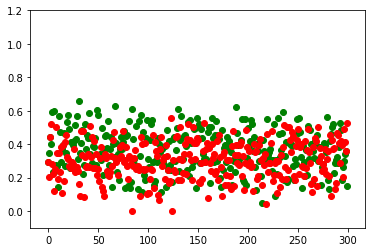

In [41]:
print('Event Tweets (wonderwoman): ', event_tweet_count('wonderwoman'))
A, B = tweets_event_ab_test('wonderwoman')
plt.scatter(range(len(A)), A, c = 'g')
plt.scatter(range(len(B)), B, c = 'r')
plt.ylim(-.1,1.2)

In [ ]:
check_score_cluster('travel ban|travelban',.7)

Event Tweets (earthquake):  1222
A1|A2:  1.0 
B1|B2:  0.978 

A1|B1:  0.21 
A2|B2:  0.192 

Cosine Similarity Mean of A2 to A1 0.864 
Cosine Similarity Mean of B2 to B1 0.31 
Cosine Similarity Mean of B2 to A1 0.058 

Cosine Similarity STD of A2 to A1 0.215 
Cosine Similarity STD of B2 to B1 0.121 
Cosine Similarity STD of B2 to A1 0.133 



(-0.1, 1.2)

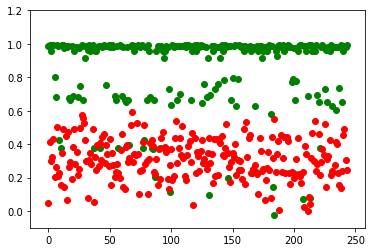

In [39]:
print('Event Tweets (earthquake): ', event_tweet_count('earthquake'))
A, B = tweets_event_ab_test('earthquake')
plt.scatter(range(len(A)), A, c = 'g')
plt.scatter(range(len(B)), B, c = 'r')
plt.ylim(-.1,1.2)

In [ ]:
Top_scored_tweets_in_B('nbafinals', n = 300000)

In [53]:
Top_scored_tweets_in_B('wonderwoman', n = 300000)

,score,tweet
110124,0.768438,movie is just wrong and was never the case. it took the discovery of ares for her to truly learn a…
175588,0.752729,my staff and i had the privilege of hosting the jaaf coaches clinic yesterday. it was great to see all the coaches ready to make an impact.
82653,0.747910,and you thought jason takes manhattan was weird. the kill count for jason goes to hell is here! watch &amp; subscribe!
88488,0.745911,got to stand in for a c section and it was the scariest/craziest yet most amazing thing i've ever seen. holy shit
25027,0.741233,"here's a blast to the past for you on this cool morning! it was 1954, the birth of an indu…"
250992,0.728807,"so some guy gave and i $20 each to cut in front of us in line at the brewery, then talked to us about sharks. it was worth. 🤑"
16308,0.723221,"the ❤️ is real! someone had brought him the food! ""it was so good i had to find y'all and come…"
135382,0.720711,"my repair guy in la was out of the shop these last 2 days, so i fixed the flight damage to the bass myself. it's 90% where it should be 🤞"
207560,0.720633,i was suppose to color this live for complex today but it got moved back to the 9th. so i'm gonna make a tutorial i…
159300,0.719219,". is a joke. it's sad, but i'm excited to see him contend for a cy young next season after being traded in the winter #lgm"


In [ ]:
Top_scored_tweets_in_B('travel Ban|travelban', n = 300000)

In [ ]:
Top_scored_tweets_in_B('paris|climate', n = 300000)